In [2]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [3]:
import gc
gc.collect()

0

In [4]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Tue Apr  2 21:44:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P8              16W / 250W |    390MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [6]:
env_id = "CartPole-v1"
# env = make_vec_env(env_id, n_envs=1)
# /mnt/nfs/work/c98181/RL/CartPole-v1/dataset
observations= np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_actions.npy", allow_pickle=True)
rewards = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_rewards.npy", allow_pickle=True)
dones = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_dones.npy", allow_pickle=True)
info = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_info.npy", allow_pickle=True)
next_obs = np.load("/mnt/nfs/work/c98181/RL/CartPole-v1/dataset/CartPole-v1_28000_next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()

# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])

# print(actions)

(28000, 4) (28000,) (28000,) (28000,) (28000,) (28000, 4)
[-0.0455423  -0.00493775  0.01715994  0.02859923] 0 1.0 False {'TimeLimit.truncated': False} [-0.04564106 -0.20030153  0.01773192  0.32664654]


In [7]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [8]:
# import numpy as np
# import gymnasium as gym
# from imitation.policies.serialize import load_policy
# from imitation.util.util import make_vec_env
# from imitation.data.wrappers import RolloutInfoWrapper
# env = make_vec_env(
#     "seals:seals/CartPole-v0",
#     rng=np.random.default_rng(),
#     post_wrappers=[
#         lambda env, _: RolloutInfoWrapper(env)
#     ],  # needed for computing rollouts later
# )
# from stable_baselines3.common.evaluation import evaluate_policy

# # reward, _ = evaluate_policy(expert, env, 10)
# print(reward)

In [9]:
policy_network = PolicyNetwork(
    4, 2).to(device)

nn.init.kaiming_normal_(policy_network.fc1.weight)
nn.init.kaiming_normal_(policy_network.fc2.weight)
nn.init.kaiming_normal_(policy_network.fc3.weight)
prev = PolicyNetwork(
    4, 2).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0017601048183920826,weight_decay=2.350251568550711e-5)
env=make_vec_env_sb3(env_id, n_envs=1)

# Training loop
num_epochs = 1
batch_size = 16

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
eval_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = 500
now_log=0
now_pos=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)

        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        model_dist = Categorical(logits=logits)
        model_act_sample = model_dist.sample()
        policy_chosen_logps = model_dist.log_prob(act_batch)
        policy_rejected_logps = model_dist.log_prob(model_act_sample)
        with torch.no_grad():
            prev_dist = Categorical(logits=prev(obs_batch))
            reference_chosen_logps = prev_dist.log_prob(act_batch)
            reference_rejected_logps = prev_dist.log_prob(model_act_sample)


        chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps


        if epoch <= -1:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 1
          desired_loss=(1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)))
          undesired_loss=(1 - F.logsigmoid(beta * (chosen_KL - reject_logratios)))
          losses = torch.cat((desired_loss, undesired_loss), 0)
        loss = losses.mean()
        # Optimize the policy
        
        optimizer.zero_grad()

        prev.load_state_dict(policy_network.state_dict())
        prev.eval()

        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = (desired_loss).detach().mean().item()
        negative_reward = (undesired_loss).detach().mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward})


        total_reward=0
        num_test=10
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"cartpole_iteration_{now_pos}.gif"
                    imageio.mimsave("/mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO/gif/"+image_path, frames)

            print(total_reward/num_test)
            eval_rewards.append(total_reward/num_test)
            policy_network.train()  # 切换回训练模式


         

env.close()

Epoch [1/1]:   1%|▏         | 23/1750 [00:00<00:30, 56.28it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.00126] /tmp/ipykernel_1378106/3560997735.py:117: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
Epoch [1/1]:   3%|▎         | 58/1750 [00:02<01:14, 22.60it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.00126] 

[73.1]


Epoch [1/1]:   5%|▌         | 93/1750 [00:04<01:16, 21.60it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=4.95e-5] 

[65.9]


Epoch [1/1]:   6%|▌         | 106/1750 [00:08<02:38, 10.35it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.000722]

[90.6]


Epoch [1/1]:   8%|▊         | 147/1750 [00:09<01:37, 16.42it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.00129] 

[98.4]


Epoch [1/1]:  10%|█         | 181/1750 [00:13<01:47, 14.59it/s, loss=1.7, positive_reward=1.7, negative_reward=1.69, margin=0.00199]   

[109.1]


Epoch [1/1]:  12%|█▏        | 216/1750 [00:16<01:48, 14.13it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=1.19e-7] 

[101.6]


Epoch [1/1]:  13%|█▎        | 229/1750 [00:19<02:57,  8.57it/s, loss=1.69, positive_reward=1.7, negative_reward=1.69, margin=0.00321]  

[127.5]


Epoch [1/1]:  15%|█▌        | 271/1750 [00:23<02:24, 10.25it/s, loss=1.7, positive_reward=1.7, negative_reward=1.7, margin=6.32e-5]    

[133.]


Epoch [1/1]:  17%|█▋        | 304/1750 [00:27<02:14, 10.72it/s, loss=1.7, positive_reward=1.7, negative_reward=1.7, margin=0.00251]    

[151.4]


Epoch [1/1]:  19%|█▉        | 338/1750 [00:30<01:58, 11.92it/s, loss=1.7, positive_reward=1.7, negative_reward=1.7, margin=0.000144]   

[136.3]


Epoch [1/1]:  21%|██▏       | 373/1750 [00:36<02:32,  9.03it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=-6.2e-6] 

[169.]


Epoch [1/1]:  22%|██▏       | 386/1750 [00:40<03:11,  7.13it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.00697] 

[155.3]


Epoch [1/1]:  25%|██▍       | 429/1750 [00:46<02:53,  7.64it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.00103] 

[140.8]


Epoch [1/1]:  26%|██▋       | 462/1750 [00:50<02:20,  9.19it/s, loss=1.69, positive_reward=1.7, negative_reward=1.69, margin=0.00792]  

[186.2]


Epoch [1/1]:  28%|██▊       | 496/1750 [00:58<03:13,  6.50it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.00295] 

[252.3]


Epoch [1/1]:  30%|██▉       | 522/1750 [01:11<05:07,  3.99it/s, loss=1.7, positive_reward=1.7, negative_reward=1.7, margin=0.00619]    

[333.8]


Epoch [1/1]:  32%|███▏      | 559/1750 [01:13<02:51,  6.95it/s, loss=1.7, positive_reward=1.71, negative_reward=1.7, margin=0.00392]   

[187.6]


Epoch [1/1]:  33%|███▎      | 573/1750 [01:24<05:43,  3.43it/s, loss=1.7, positive_reward=1.7, negative_reward=1.69, margin=0.00313]   

[308.8]


Epoch [1/1]:  35%|███▌      | 616/1750 [01:36<04:57,  3.81it/s, loss=1.69, positive_reward=1.7, negative_reward=1.69, margin=0.00482]  

[341.6]


Epoch [1/1]:  37%|███▋      | 655/1750 [01:47<04:28,  4.07it/s, loss=1.68, positive_reward=1.68, negative_reward=1.68, margin=0.00369] 

[306.]


Epoch [1/1]:  38%|███▊      | 673/1750 [01:50<03:58,  4.51it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.00311] 

[150.2]


Epoch [1/1]:  41%|████      | 710/1750 [01:55<02:52,  6.03it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=4.2e-5]  

[157.2]


Epoch [1/1]:  43%|████▎     | 745/1750 [02:08<03:49,  4.39it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.00242] 

[500.]


Epoch [1/1]:  44%|████▍     | 772/1750 [02:21<04:35,  3.55it/s, loss=1.69, positive_reward=1.69, negative_reward=1.68, margin=0.0135]  

[473.4]


Epoch [1/1]:  46%|████▋     | 812/1750 [02:27<03:01,  5.18it/s, loss=1.67, positive_reward=1.68, negative_reward=1.67, margin=0.00202] 

[250.7]


Epoch [1/1]:  47%|████▋     | 827/1750 [02:31<03:14,  4.74it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.000647]

[292.4]


Epoch [1/1]:  49%|████▉     | 866/1750 [02:43<03:28,  4.23it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=-2.07e-5]

[477.7]


Epoch [1/1]:  52%|█████▏    | 902/1750 [02:55<03:29,  4.05it/s, loss=1.71, positive_reward=1.71, negative_reward=1.71, margin=0.0056]  

[375.8]


Epoch [1/1]:  53%|█████▎    | 919/1750 [03:07<05:19,  2.60it/s, loss=1.73, positive_reward=1.73, negative_reward=1.73, margin=0.00386] 

[489.2]


Epoch [1/1]:  55%|█████▍    | 959/1750 [03:19<04:03,  3.25it/s, loss=1.69, positive_reward=1.7, negative_reward=1.69, margin=0.00493]  

[478.5]


Epoch [1/1]:  57%|█████▋    | 991/1750 [03:31<03:48,  3.33it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.000479]

[500.]


Epoch [1/1]:  58%|█████▊    | 1010/1750 [03:40<04:15,  2.90it/s, loss=1.7, positive_reward=1.7, negative_reward=1.69, margin=0.00596]   

[440.3]


Epoch [1/1]:  60%|██████    | 1054/1750 [03:51<03:08,  3.68it/s, loss=1.68, positive_reward=1.69, negative_reward=1.68, margin=0.00754] 

[390.4]


Epoch [1/1]:  62%|██████▏   | 1092/1750 [04:03<02:50,  3.86it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0]       

[500.]


Epoch [1/1]:  63%|██████▎   | 1110/1750 [04:10<03:16,  3.25it/s, loss=1.7, positive_reward=1.74, negative_reward=1.66, margin=0.0777]   

[473.9]


Epoch [1/1]:  66%|██████▌   | 1147/1750 [04:22<02:48,  3.58it/s, loss=1.69, positive_reward=1.69, negative_reward=1.68, margin=0.00635] 

[500.]


Epoch [1/1]:  68%|██████▊   | 1185/1750 [04:33<02:25,  3.89it/s, loss=1.71, positive_reward=1.71, negative_reward=1.71, margin=-.000727]

[450.3]


Epoch [1/1]:  69%|██████▊   | 1203/1750 [04:45<03:22,  2.70it/s, loss=1.71, positive_reward=1.71, negative_reward=1.7, margin=0.00374]  

[500.]


Epoch [1/1]:  71%|███████   | 1239/1750 [04:57<02:41,  3.17it/s, loss=1.7, positive_reward=1.71, negative_reward=1.7, margin=0.00881]   

[500.]


Epoch [1/1]:  73%|███████▎  | 1279/1750 [05:09<02:11,  3.58it/s, loss=1.7, positive_reward=1.7, negative_reward=1.69, margin=0.00657]   

[500.]


Epoch [1/1]:  74%|███████▍  | 1303/1750 [05:21<02:21,  3.17it/s, loss=1.69, positive_reward=1.7, negative_reward=1.68, margin=0.0129]   

[500.]


Epoch [1/1]:  76%|███████▌  | 1323/1750 [05:33<02:52,  2.47it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=5.47e-5] 

[500.]


Epoch [1/1]:  78%|███████▊  | 1366/1750 [05:44<01:55,  3.31it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=-.000777]

[500.]


Epoch [1/1]:  79%|███████▉  | 1386/1750 [05:56<02:22,  2.56it/s, loss=1.7, positive_reward=1.7, negative_reward=1.69, margin=0.00184]   

[500.]


Epoch [1/1]:  82%|████████▏ | 1428/1750 [06:08<01:38,  3.27it/s, loss=1.72, positive_reward=1.73, negative_reward=1.7, margin=0.0305]   

[500.]


Epoch [1/1]:  83%|████████▎ | 1449/1750 [06:19<01:54,  2.64it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0]       

[500.]


Epoch [1/1]:  85%|████████▌ | 1490/1750 [06:31<01:19,  3.28it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0]       

[500.]


Epoch [1/1]:  86%|████████▋ | 1511/1750 [06:42<01:29,  2.66it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.000429]

[500.]


Epoch [1/1]:  89%|████████▉ | 1554/1750 [06:49<00:49,  4.00it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0]       

[468.8]


Epoch [1/1]:  91%|█████████ | 1585/1750 [07:01<00:44,  3.72it/s, loss=1.68, positive_reward=1.68, negative_reward=1.68, margin=-2.38e-5]

[470.1]


Epoch [1/1]:  92%|█████████▏| 1603/1750 [07:12<00:55,  2.63it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=9.98e-5] 

[500.]


Epoch [1/1]:  94%|█████████▍| 1647/1750 [07:24<00:30,  3.42it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0.0011]  

[468.6]


Epoch [1/1]:  95%|█████████▌| 1666/1750 [07:36<00:32,  2.62it/s, loss=1.7, positive_reward=1.7, negative_reward=1.7, margin=0.00696]    

[500.]


Epoch [1/1]:  98%|█████████▊| 1710/1750 [07:47<00:11,  3.42it/s, loss=1.69, positive_reward=1.69, negative_reward=1.69, margin=0]       

[500.]


Epoch [1/1]:  99%|█████████▉| 1730/1750 [07:59<00:07,  2.63it/s, loss=1.71, positive_reward=1.72, negative_reward=1.71, margin=0.0126]  

[500.]


Epoch [1/1]: 100%|██████████| 1750/1750 [08:10<00:00,  3.57it/s, loss=1.71, positive_reward=1.72, negative_reward=1.71, margin=0.0126]

[500.]


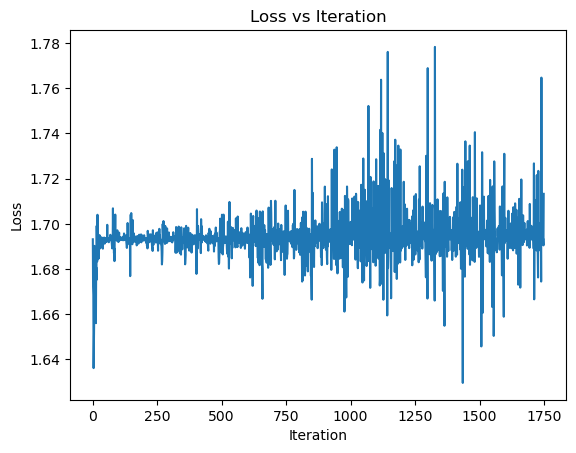

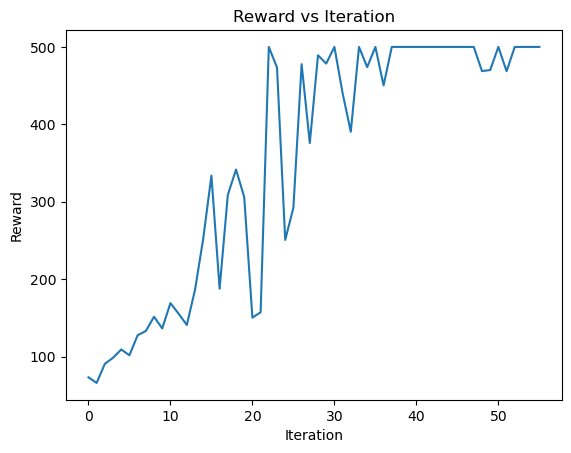

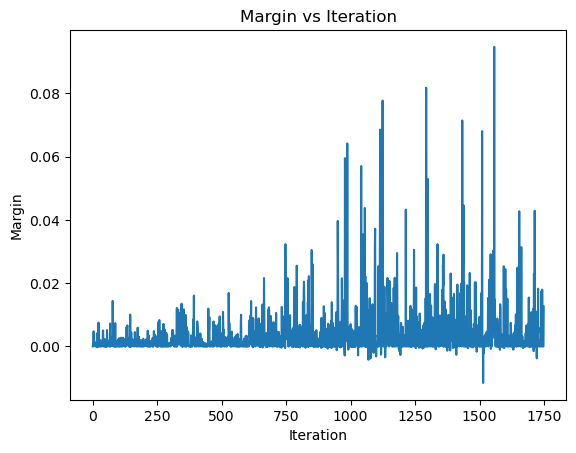

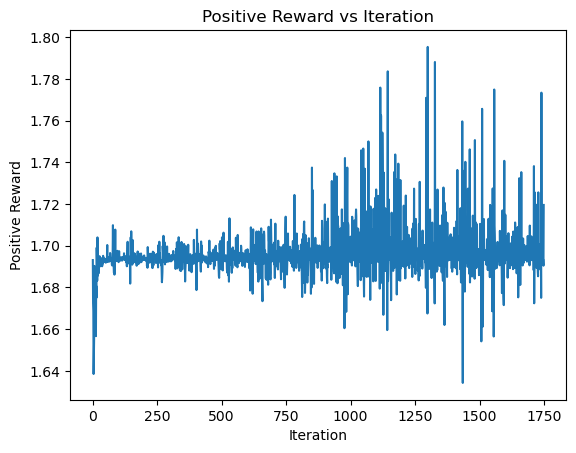

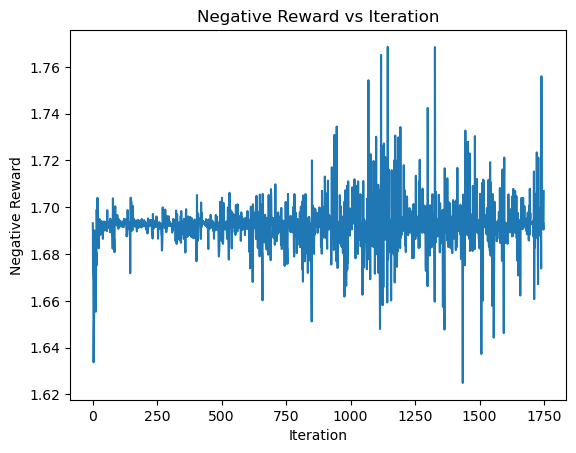

<Figure size 640x480 with 0 Axes>

In [10]:
# save all png to /mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO/loss.png")




# draw the reward graph

plt.plot(eval_rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO/reward.png")

# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO/margin.png")

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO/positive_reward.png")

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")
plt.show()
plt.savefig("/mnt/nfs/work/c98181/RL/CartPole-v1/Offline_KTO/negative_reward.png")